# Neural Networks in PyTorch
## Part 12: CIFAR-10
*Yen Lee Loh, 2021-9-8, 2022-11-23*


---
## 1. Set up and load the dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
from torch import nn        # import torch.nn as nn
import torchvision.datasets # In functional.py: patch PILLOW_VERSION--> __version__
import torchvision.transforms
from collections.abc import Iterable
rng = np.random.default_rng()
np.set_printoptions (linewidth=300)
plt.rcParams.update ({'font.family':'serif', 'font.size':13})


'''
  gallery(xnij)
  Display an array of grayscale images 
'''
def gallery(xnij, cmap='viridis', labels=None, size=1):  # size is in inches
  nmax = len(xnij)
  cols = min(20,nmax) ; rows = (nmax+cols-1)//cols
  wspace = 0.02 ; hspace = 0.02
  if isinstance (labels, Iterable) or labels!=None:   # if user has supplied labels
    hspace = .35
    
  fig,axs = plt.subplots (rows,cols, figsize=(cols*size*(1+wspace),rows*size*(1+hspace)), gridspec_kw={'wspace':wspace,'hspace':hspace})
  if nmax==1: axs = np.array([[axs]])
  axs = axs.flatten()
  for ax in axs:
      ax.axis ('off')
  for n in range(nmax):
      ax = axs[n]
      if isinstance (cmap, Iterable) and not isinstance (cmap, str):
        c = cmap[n]
      else:
        c = cmap
      ax.imshow (xnij[n], cmap=c)
      ax.set_aspect('equal')
      if isinstance (labels, Iterable):
        ax.set_title (str(labels[n]))

'''
    totalExamples,misclassifiedExamples,confusionMatrix = metrics (modelOutputs, trueOutputs)
'''
def metrics (Yn, yn):
  nmax = len(yn)
  ymax = max(yn)+1
  confmat = np.zeros ([ymax, ymax], dtype=int)   # confmat[Y][y]
  for n in range(nmax): confmat[yn[n], Yn[n]] += 1
  ntot = np.sum(confmat)
  nerr = ntot - np.trace(confmat)
  return ntot,nerr,confmat

'''
    xT,yT,xV,yV = select (MNISTinputs, MNISToutputs, [5,6,8], [100,100,100], [200,200,200])

    Given a set of inputs and outputs, 
    construct a training set consisting of the first 100 5's, 100 6's, 100 8's, 
    and a validation set consisting of the next 200 5's, 200 6's, and 200 8's.
    If the original set has fewer than 300 5's, 6's, or 7's, raise an exception.
'''
def select (inputs, outputs, classes, nT, nV, shuffle=False):
  assert len(classes) == len(nT) and len(nT) == len(nV)
  allT = []
  allV = []
  for k in range(len(classes)):
    indices, = np.where(outputs==classes[k])
    ntot = len(indices)
    indices = rng.choice (indices, nT[k] + nV[k], False)    # randomly choose 300
    indicesT,indicesV = np.split (indices, [nT[k]])
    allT += indicesT.tolist()
    allV += indicesV.tolist()
    print ('For class {}, given {} examples, we chose {} for training and {} for validation. '.format(classes[k], ntot, len(indicesT), len(indicesV)))
  if shuffle:
    rng.shuffle (allT)
    rng.shuffle (allV)
  return inputs[allT], outputs[allT], inputs[allV], outputs[allV]

In [2]:
#================ DOWNLOAD CIFAR-10 DATASET
dataset = torchvision.datasets.CIFAR10('CIFAR10', download=True, train=True, transform=torchvision.transforms.ToTensor())
loader = torch.utils.data.DataLoader(dataset, batch_size=50000, shuffle=False)
inputs,outputs = next(iter(loader))

Files already downloaded and verified


In [3]:
#================ EXAMINE GLOBAL PROPERTIES OF DATASET
print ("inputs.shape  =", inputs.shape)
print ("outputs.shape =", outputs.shape)
print ("populations of each of 10 classes =", np.bincount (outputs))

inputs.shape  = torch.Size([50000, 3, 32, 32])
outputs.shape = torch.Size([50000])
populations of each of 10 classes = [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]


---
## 2. Select two classes for binary classification

In [5]:
class0,class1 = 2,3
#xncijT,ynT,xncijV,ynV = select (inputs, outputs, [class0,class1], [20,20], [20,20], shuffle=True) 
xncijT,ynT,xncijV,ynV = select (inputs, outputs, [class0,class1], [1000,1000], [1000,1000], shuffle=True) 
xndT = xncijT.flatten (1,-1) ; yndT = (ynT.reshape (-1,1) - class0) / (class1-class0)
xndV = xncijV.flatten (1,-1) ; yndV = (ynV.reshape (-1,1) - class0) / (class1-class0)
_,cmax,imax,jmax = xncijT.shape
_,dmax = xndT.shape

For class 2, given 5000 examples, we chose 1000 for training and 1000 for validation. 
For class 3, given 5000 examples, we chose 1000 for training and 1000 for validation. 


---
## 3. Examine the dataset

In [6]:
#================ FOR DISPLAY PURPOSES, WE WANT THE CHANNEL INDEX TO BE FASTEST-VARYING
xnijcT = xncijT.permute([0,2,3,1])
print ("xncijT.shape   =", xncijT.shape)  # 40 images, 3 channels, 32x32 pixels
print ("xnijcT.shape   =", xnijcT.shape)  # 40 images, 32x32 pixels, 3 channels (RGBRGBRGB...)

xncijT.shape   = torch.Size([2000, 3, 32, 32])
xnijcT.shape   = torch.Size([2000, 32, 32, 3])


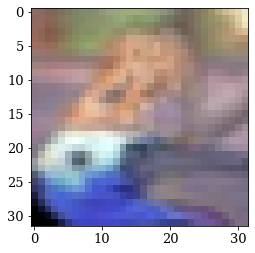

In [7]:
#================ EXAMINE FIRST TRAINING EXAMPLE
plt.imshow (xnijcT[0]);

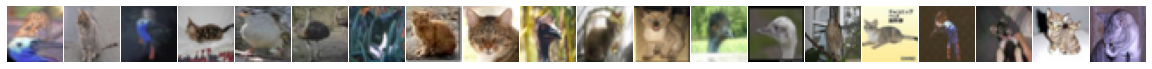

In [8]:
#================ EXAMINE FIRST FEW TRAINING EXAMPLES
gallery (xnijcT[:20]  )

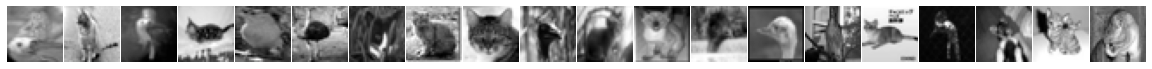

In [10]:
#================ CONVERT TO GRAYSCALE
xnijT = torch.mean(xncijT, axis=1)    # average over RGB channels
xnijV = torch.mean(xncijV, axis=1)    # average over RGB channels
gallery (xnijT[:20], cmap='gray')

In [11]:
xndT = xnijT.flatten (1,-1) ; yndT = (ynT.reshape (-1,1) - class0) / (class1-class0)
xndV = xnijV.flatten (1,-1) ; yndV = (ynV.reshape (-1,1) - class0) / (class1-class0)
_,imax,jmax = xnijT.shape
_,dmax = xndT.shape

---
## 5. Train CNN on grayscale images

In [15]:
def fractionalError (Ynd, ynd):
  yn = ynd.detach().round().flatten() #.astype(int)
  Yn = Ynd.detach().round().flatten() #.astype(int)
  return torch.mean( (Yn - yn)**2 )

def trainAndValidate (xndT, yndT, xndV, yndV, model, loss, optimizer, epochs=10000, lossTarget=0.0001, statsInterval=1, reportInterval=20):
  history = []
  for t in range(epochs):        # t is the epoch number
    model.train()                # put model in training mode
    YndT = model(xndT)           # uppercase Y = model prediction
    FT = loss(YndT,yndT)
    FT.backward()
    optimizer.step()
    optimizer.zero_grad()
    FT = FT.item()
    
    if t % statsInterval == 0:
      model.eval()
      YndV = model(xndV)
      FV = loss(YndV,yndV);
      FV = FV.item()
      errT = fractionalError (YndT, yndT)
      errV = fractionalError (YndV, yndV)
      history.append ([t, FT, FV, errT, errV])
    if t % reportInterval == 0:
      print ('Epoch {:5}  Training loss = {:.4f}  Training error = {:.2f}%  Validation error = {:.2f}%'.format(t,FT,100*errT,100*errV))
      if FT < lossTarget:
        print('Training loss achieved goal!')
        return history
  print ('Training loss did NOT achieve goal!\n')
  return history

In [16]:
model = nn.Sequential(               # 32x32
  nn.Unflatten (1, (1,32,32)),       # 1x32x32
  nn.Conv2d    (1, 20, 5),            #??x28x28
  nn.ReLU(),
  nn.Conv2d    (20, 40, 5),  #??x24x24
  nn.ReLU(),
  nn.Conv2d    (40, 60, 5),  #??x20x20
  nn.ReLU(),
  nn.Conv2d    (60, 80, 5),  #??x16x16
  nn.ReLU(),
  nn.Conv2d    (80, 100, 5),  #??12x12
  nn.ReLU(),
  #nn.MaxPool2d (2),                     # 8x14x14
  nn.Conv2d    (100, 120, 3),           # 16x10x10   At
  nn.ReLU(),
  nn.MaxPool2d (2),                  # 16x5x5
  nn.Flatten(),    
  nn.Linear(120*5*5,200),              # 84
  nn.ReLU(),
  nn.Linear(200,1),                   # 1
  nn.Sigmoid()
)
XNDT = xndT.cuda()
YNDT = yndT.cuda()
XNDV = xndV.cuda()
YNDV = yndV.cuda()
MODEL = model.cuda()
LOSS = nn.BCELoss()
OPTIMIZER = torch.optim.Adam (MODEL.parameters(), lr=0.001)
history = trainAndValidate (XNDT, YNDT, XNDV, YNDV, MODEL, LOSS, OPTIMIZER)

Epoch     0  Training loss = 0.6934  Training error = 50.00%  Validation error = 50.00%
Epoch    20  Training loss = 0.6649  Training error = 38.95%  Validation error = 39.90%
Epoch    40  Training loss = 0.6072  Training error = 33.30%  Validation error = 34.95%
Epoch    60  Training loss = 0.5660  Training error = 29.25%  Validation error = 33.35%
Epoch    80  Training loss = 0.4937  Training error = 23.55%  Validation error = 32.95%
Epoch   100  Training loss = 0.4298  Training error = 19.75%  Validation error = 31.35%
Epoch   120  Training loss = 0.3086  Training error = 13.10%  Validation error = 30.85%
Epoch   140  Training loss = 0.4397  Training error = 20.25%  Validation error = 33.10%
Epoch   160  Training loss = 0.2776  Training error = 13.25%  Validation error = 32.95%
Epoch   180  Training loss = 0.1236  Training error = 4.80%  Validation error = 32.40%
Epoch   200  Training loss = 0.4237  Training error = 19.80%  Validation error = 34.30%
Epoch   220  Training loss = 0.21

KeyboardInterrupt: 

In [ ]:
history = torch.tensor (history)

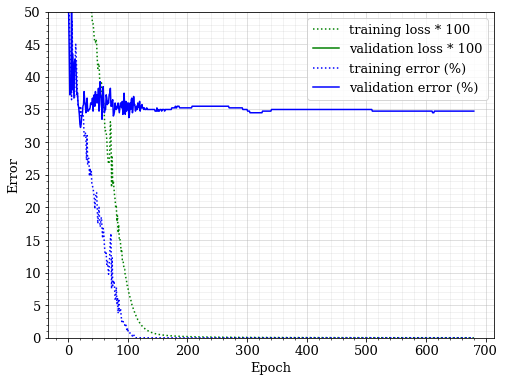

In [52]:
figure = plt.figure(figsize=(8,6))
t,FT,FV,errT,errV = history.T
plt.plot (t, 100*FT, 'g:', label='training loss * 100')
plt.plot (t, 100*FV, 'g-', label='validation loss * 100')
plt.plot (t, 100*errT, 'b:', label='training error (%)')
plt.plot (t, 100*errV, 'b-', label='validation error (%)')
plt.xlabel ("Epoch"); plt.ylabel ("Error")
plt.minorticks_on(); plt.yticks(np.arange(0,100,5)) ; plt.ylim ([0,50])
plt.grid (which='major', alpha=0.5)
plt.grid (which='minor', alpha=0.2)
plt.legend();

In [55]:
#================ EVALUATE ACCURACY FOR BOTH TRAINING AND VALIDATION SETS
model = MODEL.cpu()
model.eval()             # choose evaluation mode
YndT = model(xndT)
YndV = model(xndV)
YnT = YndT.detach().numpy().round().flatten().astype(int)  # round to either 0 or 1
ynT = yndT.detach().numpy().flatten().astype(int)          # this is already an integer
YnV = YndV.detach().numpy().round().flatten().astype(int)  # round to either 0 or 1
ynV = yndV.detach().numpy().flatten().astype(int)          # this is already an integer

ntot,nerr,Cnn = metrics (YnT, ynT)
print("Training error   = {:4d}/{:} = {:4.1f}%    Confusion matrix = {}".format (nerr, ntot, 100*nerr/ntot, Cnn.tolist()))
ntot,nerr,Cnn = metrics (YnV, ynV)
print("Validation error = {:4d}/{:} = {:4.1f}%    Confusion matrix = {}".format (nerr, ntot, 100*nerr/ntot, Cnn.tolist()))


Training error   =    0/400 =  0.0%    Confusion matrix = [[200, 0], [0, 200]]
Validation error =  161/400 = 40.2%    Confusion matrix = [[134, 66], [95, 105]]
